Extract Data

Extract kanjivg_modified.tar.gz into working directory

In [ ]:
# imports 
import tarfile
from os import path, chdir

# constants 
working_directory = "/content/drive/My Drive/train_local_model/"

# setup environment
chdir(working_directory)

# extract tar file of svg's
fname = './assets/kanji_modified.tar.gz'

if not path.isdir('./assets/kanji_modified'):
  print('kanji modified svgs not found !, extracting ...')
  tar = tarfile.open(fname, "r:gz")
  tar.extractall(path="./assets/")
  tar.close()

Data Generator 

Extract Modified svg's and create data batches to feed into the model

In [ ]:
from local_strokegenerator import *

# data generator

def inp_data_generator(filelist, epochs, steps_per_epoch, batch_size):
  for epoch in range(epochs):
    # get a new generator, same dataset on each epoch
    stroke_gen = strokeGenerator(filelist)
    for step in range(steps_per_epoch):
      # place holder for samples generated every batch
      inp_batch = []
      ext_batch = []
      touch_batch = []
      cropped_batch = []  
      for batch in range(batch_size):
        inp, ext, touch, croppedimg = next(stroke_gen)
        inp_batch.append(inp)
        ext_batch.append(ext)
        touch_batch.append(touch)
        cropped_batch.append(np.reshape(croppedimg, 5*5)) # reshape 5 * 5 image to array of length 25 
      yield [np.array(inp_batch), np.array(ext_batch)], [np.array(touch_batch), np.array(cropped_batch)] # [x1, x2], [y1, y2]

Constants and Magic Numbers

In [ ]:
batch_size = 128
epochs = 20

from os import walk
path = "./assets/kanji_modified/"
_, _, filelist = next(walk(path))

print("file count : ", len(filelist))

file count :  11401


In [ ]:
train_samples = 1700000
train_files = filelist
train_steps_per_epoch = train_samples // batch_size

validation_samples = 40000
validation_files = filelist[::-1]# get samples from end of file list
validation_steps_per_epoch = validation_samples // batch_size

train_data = inp_data_generator(train_files, epochs, train_steps_per_epoch, batch_size)
validation_data = inp_data_generator(validation_files, epochs + 3, validation_steps_per_epoch, batch_size)

Residual Block 

Convolution channels in each of four blocks are [[16,16], [16,32], [32,32],[32,64]]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

# force graph building by disabling eager execution
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

In [ ]:
#residual module
inp_img_dim = [100, 100, 3]
inp_ext_dim = [3]
# test : 1*1 conv before add layer
inp = Input(shape=(100, 100, 16))
x = BatchNormalization()(inp)
x = Activation("relu")(x)
x = Conv2D(16, 3,padding="same")(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(16, 3,padding="same")(x)
out = add([x, inp])
res_block_16 = Model(inputs=inp, outputs=out)

inp = Input(shape=(100, 100, 16))
x = BatchNormalization()(inp)
x = Activation("relu")(x)
x = Conv2D(16, 3,padding="same")(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(16, 3,padding="same")(x)
out = add([x, inp])
res_block_16_1 = Model(inputs=inp, outputs=out)

#residual module
inp = Input(shape=(100, 100, 16))
x = BatchNormalization()(inp)
x = Activation("relu")(x)
x = Conv2D(16, 3,padding="same")(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(32, 3,padding="same")(x)
if not inp.shape[-1] == 32:
  #project with 1x1 convolution
  con = Conv2D(32,1)(inp)
out = add([x, con])
res_block_32 = Model(inputs=inp, outputs=out)

#residual module
inp = Input(shape=(100, 100, 32))
x = BatchNormalization()(inp)
x = Activation("relu")(x)
x = Conv2D(16, 3,padding="same")(x) 
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(64, 3,padding="same")(x)
if not inp.shape[-1] == 64:
  #project with 1x1 convolution
  con = Conv2D(64,1)(inp)
out = add([x, con])
res_block_64 = Model(inputs=inp, outputs=out)

Building Model

4 Block Residual block with dynamic tensor extraction 

two input, two output model (keras functional API)

In [ ]:
# tensor slice 
def slice_return(x):
  return tf.slice(x[0], x[1], [5,5,64])

#creating local model
inp = Input(shape = inp_img_dim, dtype=tf.float32, name = "lg_inp")
ext_inp = Input(shape = inp_ext_dim, dtype = tf.int32, name = "ext_inp")

# initilization layer, helpful in transfer learning, due to different input layers, between global and local models
conv = Conv2D(16, 3, padding='same')(inp)
#four residual block stacked 
x_a = res_block_16(conv) 
x_a = res_block_16_1(x_a) 
x_a = res_block_32(x_a) 
x_a = res_block_64(x_a)

# now x is 95 * 65 * 54 res encoded tensor, now carry out extraction procedure to enforce localization
# batch_size is Dynamic, Unknown or of type None, hence using map_fn to iterate over dimention '0' --> None
extracted_tensor = tf.map_fn(slice_return, elems = (x_a, ext_inp), fn_output_signature=tf.float32)

x_0 = Flatten()(extracted_tensor) #flatten and feed to dense layer

#fully connected layer 1

# x1 = Dense(256, activation='relu')(x_0)

x1 = Dense(128, activation='relu')(x_0)

#fully connected layer 2

x2 = Dense(1, activation='sigmoid', name = 'out_touch')(x1)

#fully connected layer 3
x3 = Dense(25, activation='softmax', name = 'out_cropped')(x1)

# x3 = tf.reshape(x3, (5,5)) #output a 5 * 5 image

model = Model(inputs= [inp, ext_inp], outputs= [x2,x3])

model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
lg_inp (InputLayer)             [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 100, 100, 16) 448         lg_inp[0][0]                     
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 100, 100, 16) 4768        conv2d_10[0][0]                  
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 100, 100, 16) 4768        functional_1[0][0]               
_______________________________________________________________________________________

In [ ]:
model.compile(loss=[tf.keras.losses.BinaryCrossentropy(),tf.keras.losses.CategoricalCrossentropy()],
              optimizer='adam', metrics = ['accuracy'], loss_weights = [0.2, 1])

In [ ]:
# call backs to ensure optimal training
from tensorflow.keras.callbacks import EarlyStopping 

early_stop = EarlyStopping(monitor="val_out_cropped_loss", mode="min")

In [ ]:
history = model.fit(train_data, validation_data = validation_data, validation_steps = validation_steps_per_epoch, steps_per_epoch =  train_steps_per_epoch, epochs = epochs, callbacks = [early_stop])

Epoch 1/20
13281/13281 [==============================] - ETA: 0s - batch: 6640.0000 - size: 128.0000 - loss: 0.1208 - out_touch_loss: 0.0016 - out_cropped_loss: 0.1205 - out_touch_accuracy: 0.9996 - out_cropped_accuracy: 0.9565WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
13281/13281 [==============================] - 6182s 465ms/step - batch: 6640.0000 - size: 128.0000 - loss: 0.1208 - out_touch_loss: 0.0016 - out_cropped_loss: 0.1205 - out_touch_accuracy: 0.9996 - out_cropped_accuracy: 0.9565 - val_loss: 0.1075 - val_out_touch_loss: 1.6939e-04 - val_out_cropped_loss: 0.1075 - val_out_touch_accuracy: 0.9999 - val_out_cropped_accuracy: 0.9597
Epoch 2/20
13281/13281 [================

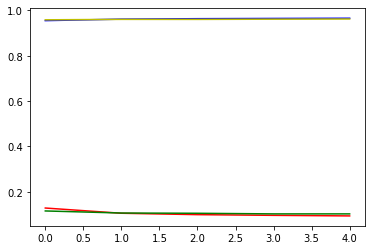

In [ ]:
import matplotlib.pyplot as plt
history = history.history
plt.plot(history['loss'], 'r', label="train_loss")
plt.plot(history['val_loss'], 'g', label='validation_loss')
plt.plot(history['out_cropped_accuracy'], 'b', label='train_cropped_accuracy')
plt.plot(history['val_out_cropped_accuracy'], 'y', label = 'validation accuracy')
plt.savefig('local_model_firstattempt', fmt='PNG')

In [ ]:
# test model loss and accuracy
from random import sample

test_filelist = sample(filelist[::-1], 1000) # choose 1000 random files

test_data = inp_data_generator(test_filelist, 1, 10, 64)

loss, touch_loss, cropped_loss, touch_accuracy, cropped_accuracy =  model.evaluate(test_data, steps = 10)
print('testing model on random data from dataset total loss : %f, touch_loss : %f, cropped_loss = %f, touch_accuracy : %f, cropped_accuracy : %f' % (loss, touch_loss, cropped_loss, touch_accuracy, cropped_accuracy))

testing model on random data from dataset total loss : 0.087605, touch_loss : 0.000001, cropped_loss = 0.087605, touch_accuracy : 1.000000, cropped_accuracy : 0.970312


In [ ]:
# save residiual block weights for transfer learning
res_blocks = {'res_block_16' : res_block_16, 'res_block_16_1' : res_block_16_1, 'res_block_32' : res_block_32, 'res_block_64' : res_block_64}

res_blocks_path = './res_block_weights/'
for key, item in res_blocks.items():
  item.save_weights(res_blocks_path + key)

In [ ]:
# save whole model weights for inference
model.save_weights("saved_weights/local_model_trained_17mil")